In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import json
import io
import time
import numpy.random as rnd
import numpy.linalg as linalg
import datetime

## Collecting data

In [2]:
N = 200 ## the number of samples we want to collect


cities = [ ## some cities scattered over the world (between polar circles though)
  {'name': 'New York', 'pos': [40.7128, -74.0060]},
  {'name': 'Beijing', 'pos': [39.9042, 116.4074]},
  {'name': 'Buenos Aires', 'pos': [-34.6037, -58.3816]},
  {'name': 'Lisboa', 'pos': [38.7223, -9.1393]},
  {'name': 'Makassar', 'pos': [-5.1477, 119.4327]},
  {'name': 'Ushuaia', 'pos': [-54.8019, -68.3030]},
  {'name': 'Mumbai', 'pos': [19.0760, 72.8777]},
  {'name': 'Istanbul', 'pos': [41.0082, 28.9784]},
  {'name': 'Nairobi', 'pos': [-1.2921, 36.8219]},
  {'name': 'Sydney', 'pos': [-33.8688, 151.2093]},
  {'name': 'Los Angeles', 'pos': [34.0522, -118.2437]},
  {'name': 'Cape Town', 'pos': [-33.9249, 18.4241]},
  {'name': 'Noumea', 'pos': [-22.2735, 166.4481]},
  {'name': 'Tokyo', 'pos': [35.6762, 139.6503]}
  ]

epoch_2020 = datetime.datetime(2020,1,1).timestamp()
ordinal_2020 = datetime.date(2020,1,1).toordinal()
epoch_2019 = datetime.datetime(2019,1,1).timestamp()
ordinal_2019 = datetime.date(2019,1,1).toordinal()
year_duration_s = epoch_2020 - epoch_2019

def random_date_in_2019():
    return datetime.date.fromordinal(random.randrange(ordinal_2019, ordinal_2020))

def generate_data_template(N):
    ret = []
    for i in range(N):
        city = random.choice(cities)
        date = random_date_in_2019()
        m = {}
        m.update(city)
        m.update({'date': date.isoformat(), 'daylight': '?'})
        ret.append(m)
    def sortfn(m):
        return m['name'] + '|' + m['date']
    return sorted(ret, key=sortfn)

def print_data_template_as_json(template, out):
    out.write('[\n')
    for i in range(len(template)):
        if(i > 0):
            out.write(',\n')
        m = template[i]
        out.write(json.dumps(m))
    out.write('\n]\n')

def write_data_template_to_file():
    random.seed(38)
    template = generate_data_template(N)
    with open('./data/day-durations-template.json', 'w') as outfile:
        print_data_template_as_json(template, outfile)

We can now generate a data template to be filled manually by evaluating:

In [3]:
#write_data_template_to_file()

## Generic functions across all models

In [5]:
raw_training_data = json.load(io.open("./data/day-durations-training.json"))
raw_test_data = json.load(io.open("./data/day-durations-test.json"))

def parse_daylight_s(dl_raw):
    hours, minutes = dl_raw.split(':')
    return (3600 * float(hours)) + (60 * float(minutes))

def parse_year_fraction(date_raw, lng):
    ## TODO use lng
    y,m,d = date_raw.split('-')
    return (datetime.datetime(int(y),int(m),int(d)).timestamp() - epoch_2019) / year_duration_s

    
def daylight_durations(raw_data):
    arr = []
    for m in raw_data:
        arr.append(parse_daylight_s(m['daylight']))
    return np.array(arr)
        
daylight_durations(raw_training_data)

def rms_test_error(predicted_daylight_durations, actual_daylight_durations):
    return np.sqrt(np.average((predicted_daylight_durations - actual_daylight_durations)**2))

june21_yf = parse_year_fraction("2019-06-21", 0) ## The year fraction of the Summer Solstice
day_duration_s = 86400

## Model 1: a simple linear model

In [6]:

def model1_design_matrix(raw_data):
    """
    Processes the raw data into a matrix suitable for inferring model parameters via a linear regression.
    The first 2 columns are basis functions, the last one is the target.
    """
    rows = []
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = year_f * (2 * np.pi)
        tan_phi = np.tan(lat * np.pi / 180)
        night_fraction = (1 - dl_s / day_duration_s)
        target = np.cos(np.pi * night_fraction)
        rows.append([
          (tan_phi * np.cos(psi)),
          (tan_phi * np.sin(psi)),
          target
          ])
    return np.array(rows)
        
#mat = model1_design_matrix(raw_data)

def model1_fit_alpha_and_sf(raw_data):
    mat = model1_design_matrix(raw_data)
    N = len(raw_data)
    best_fit = linalg.lstsq(mat[:,0:-1], mat[:,-1], rcond=None)
    A,B = best_fit[0]
    alpha = np.arcsin((A**2 + B**2)**0.5)
    solstice_fraction = np.arccos(A / np.sin(alpha)) / (2 * np.pi)
    rmse = np.sqrt(best_fit[1][0] / N)
    return (alpha, solstice_fraction, rmse, best_fit)

m1_alpha, m1_sf, _, m1_lsqfit = model1_fit_alpha_and_sf(raw_training_data)

## What are the inferred model parameters, in human form?
def year_fraction_to_date(sf):
    return datetime.datetime.fromtimestamp(datetime.datetime(2019,1,1).timestamp() + sf * year_duration_s)

print('Inferred Earth tilt (alpha) and sostice date with linear regression: {:.2f}, {}'.format(m1_alpha * 180 / np.pi, year_fraction_to_date(m1_sf).ctime())) ## 25.022396735018944°


Inferred Earth tilt (alpha) and sostice date with linear regression: 25.55, Sat Jun 22 06:06:50 2019


What's the prediction error?

In [7]:

## What's the prediction error?
def model1_daylight_predictions(raw_data, alpha, solstice_fraction):
    mat = model1_design_matrix(raw_data)
    sf2pi = 2 * np.pi * solstice_fraction
    p_cos_pi_nf = np.sin(alpha) * (np.cos(sf2pi ) * mat[:,0] + np.sin(sf2pi) * mat[:,1])
    return day_duration_s * (1 - np.arccos(p_cos_pi_nf) / np.pi)

rms_test_error(model1_daylight_predictions(raw_test_data, m1_alpha, m1_sf), daylight_durations(raw_test_data)) ## 668.9611997734474 s, so about 11 minutes


668.9611997734474

That's a standard error of about 11 minutes, out of day lenghts of about 12 hours. It's not *that* bad.

### Model 1 bis - let's say we know the date of the solstice, and only infer alpha

In [8]:
psi_sf = 2 * np.pi * june21_yf

def fit_alpha_at_solstice(raw_data):
    mat = model1_design_matrix(raw_data)
    features = np.cos(psi_sf) * mat[:,0:1] + np.sin(psi_sf) * mat[:,1:2]
    best_fit = linalg.lstsq(features, mat[:,-1], rcond=None)
    sin_alpha = best_fit[0][0]
    alpha = np.arcsin(sin_alpha)
    rmse = np.sqrt(best_fit[1][0] / N)
    return (alpha, rmse, best_fit)

m1_alpha_2, _rmse, _ = fit_alpha_at_solstice(raw_training_data)

print('Inferred alpha with northern summer solstice at the correct date: {:.2f}'.format(m1_alpha_2 * 180 / np.pi)) ## 25.022396735018944°


Inferred alpha with northern summer solstice at the correct date: 25.51


Not much difference, as we see. But because we now only have one basis function, we can more easily plot visually the data and fitted curves:

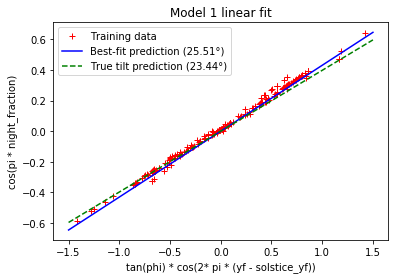

In [9]:
real_tilt = 23.44 * np.pi / 180

def plot_model1_bis_fit(raw_data, fit_alpha):
    mat = model1_design_matrix(raw_data)
    x_range = np.linspace(-1.5, 1.5, 100)
    plt.plot(
        np.cos(psi_sf) * mat[:,0] + np.sin(psi_sf) * mat[:,1],
        mat[:,2],
        'r+',
        label="Training data")
    plt.plot(
        x_range,
        np.sin(fit_alpha) * x_range,
        'b',
        label="Best-fit prediction ({:.2f}°)".format(fit_alpha * 180 / np.pi))
    plt.plot(
        x_range,
        np.sin(real_tilt) * x_range,
        'g--',
        label="True tilt prediction ({:.2f}°)".format(real_tilt * 180 / np.pi))
    ax = plt.gca()
    ax.set_title('Model 1 linear fit')
    ax.set_ylabel('cos(pi * night_fraction)')
    ax.set_xlabel('tan(phi) * cos(2* pi * (yf - solstice_yf))')
    plt.legend()
    plt.show()

plot_model1_bis_fit(raw_training_data, m1_alpha_2)

Let's see what the standard error looks like in the parameters landscape:

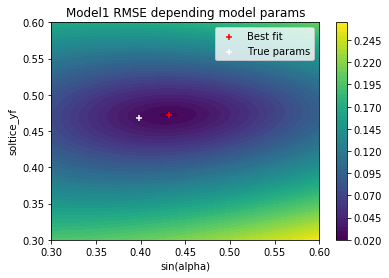

In [10]:
def plot_model1_rms(raw_data, fit_alpha, fit_soltice_yf):
    sin_alphas = np.linspace(0.3, 0.6, 5e2) ## sin alphas
    soltice_yearfs = np.linspace(0.3, 0.6, 5e2) ## solstice year_f

    C = np.zeros((np.shape(soltice_yearfs)[0], np.shape(sin_alphas)[0]))
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        tan_phi = np.tan(lat * np.pi / 180)
        night_fraction = (1 - dl_s / day_duration_s)
        target = np.cos(np.pi * night_fraction)
        Rn = (target -  tan_phi * np.matmul(np.transpose(np.mat(np.cos(2 * np.pi * (year_f - soltice_yearfs)))), np.mat(sin_alphas)))
        C += np.square(Rn)
    C = (C / N) ** 0.5

    ## Plotting the square root squared residuals for various values of sin(alpha) (vertical asin_alphasis) and solstice_yf (horizontal asin_alphasis). Lower (colder) is a better fit.
    fig, (ax0) = plt.subplots(nrows=1)
    im = ax0.contourf(sin_alphas, soltice_yearfs, C, 50)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('Model1 RMSE depending model params')
    ax0.scatter(np.array([np.sin(fit_alpha)]), np.array([fit_soltice_yf]), marker='+', color='r', label="Best fit")
    ax0.scatter(np.array([np.sin(real_tilt)]), np.array([june21_yf]), marker='+', color='w', label="True params")
    ax0.yaxis.set_label_text('soltice_yf')
    ax0.xaxis.set_label_text('sin(alpha)')
    ax0.legend()
    plt.show()

plot_model1_rms(raw_training_data, m1_alpha, m1_sf)  

## Model 2: accounting for an excess angle $\epsilon$

### Refined physical model

<img src="./img/earth-tilt-sketch.jpg" />

Let's try refining our model. We'll start from the assumption that *some phenomenon* is causing our model to be slightly inaccurate - it could be the fact that the Sun is not punctual, or maybe atmospheric refraction... Whatever that *some phenomenon* is, we'll assume it respects a symmetry around the Earth-Sun axis.

This means that the sunlight covers a little more than half a sphere: **it 'overflows' by a small angle $\epsilon$.** Because the Earth orbit is close to circular, we'll assume that this angle is constant over time.

In addition to the Earth tilt $\alpha$, we'll now try to infer $\epsilon$ from the data.

The geometric modeling is a bit more involved here, but eventually I reached the following formula:

$$ \cos(\pi p_{night}) = \sin(\epsilon) \frac{1}{\cos(\phi)\cos(\theta)} + \sin(\theta)\tan(\phi) $$

Recalling that $\sin(\theta) = \sin(\alpha)\cos(\psi)$ and that $cos(\theta) = \sqrt{1 - \sin(\theta)^2}$, we get:

$$ \cos(\pi p_{night}) = \frac{\sin(\epsilon)}{\cos(\phi)\sqrt{1 - \sin(\alpha)^2 \cos(\psi)^2}} + \sin(\alpha) \cos(\psi)\tan(\phi) $$

Remember, our goal is to infer $\alpha$ and $\epsilon$; we'll do that by inferring $u := \sin(\alpha)$ and $v := \sin(\epsilon)$. This yields the following **non-linear model in parameters $u$ and $v$:**

$$ \cos(\pi p_{night}) = \frac{v}{\cos(\phi)\sqrt{1 - u^2 \cos(\psi)^2}} + u\cos(\psi)\tan(\phi) $$

This is not a linear model, so we won't be able to directly apply least-squares linear regression as we did for Model 1. But it doesn't mean that we can't apply least-squares regression at all: it only means that the resulting optimization problem is more difficult to solve.

### Optimization

We'll solve the optimization problem of least-squares fitting $u$ and $v$ to the data using a numerical algorithm.

In [14]:
import scipy.optimize as opt
import sympy as sy
from sympy.utilities.lambdify import lambdify

Now, the parameter space that this algorithm has to explore is really quite small - a bounded box of 2 dimensions. So we could just use a 'brute-force' algorithm to find the best fit.

However I find it much more exiting to use an algorithm that makes use of differential information such as the gradient and hessian, and it gives me an occasion to show off some symbolic computing as well.

Indeed, I could compute the gradient and Hessian by hand from the above formula, but I'm really terrible at this sort of calculation, so I'll let the machine do it for me:

In [26]:
t_n, phi_n, psi_n, u, v = sy.symbols('t_n phi_n psi_n u v')

p_n = (v / ((sy.cos(phi_n) * sy.sqrt(1 - (sy.cos(psi_n) * u)**2)))) + (u * sy.tan(phi_n) * sy.cos(psi_n)) ## the prediction
g_n = t_n - p_n ## residual
e_n = (g_n ** 2) / 2 ## squared error

In [34]:
e_n

(t_n - u*cos(psi_n)*tan(phi_n) - v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)))**2/2

What do these derivatives look like? Let's look at an example of second derivative:

In [29]:
sy.diff(e_n, u, v)

(u*v*cos(psi_n)/((-u**2*cos(psi_n)**2 + 1)**(3/2)*cos(phi_n)) + u*(-t_n + u*cos(psi_n)*tan(phi_n) + v/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n)))*cos(psi_n)/(-u**2*cos(psi_n)**2 + 1) + tan(phi_n))*cos(psi_n)/(sqrt(-u**2*cos(psi_n)**2 + 1)*cos(phi_n))

Ugh, alright, I'm happy not to have done it by hand.

Now, we'll use `scipy.optimize` to minimize the sum of squared errors, while leaving the heavy lifting of evaluating the error and its derivatives to `sympy`. Because this is a small-dimensional problem and we have exact derivative information, we'll use the `trust-exact` method:

In [32]:
def model2_feature_matrix(raw_data):
    rows = []
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = (year_f - june21_yf) * (2 * np.pi)
        phi = lat * np.pi / 180
        night_fraction = (1 - dl_s / day_duration_s)
        t = np.cos(np.pi * night_fraction)
        rows.append([
          phi,
          psi,
          t
          ])
    return np.array(rows)

def model2_fit_params(raw_data):
    feat_mat = model2_feature_matrix(raw_data)

    t = feat_mat[:,2]
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    
    lam_en = lambdify([t_n, phi_n, psi_n, u, v], e_n)
    def squared_error(u_v):
        u, v = u_v
        return np.average(lam_en(t, phi, psi, u, v))

    jac_lambdas = [lambdify([t_n, phi_n, psi_n, u, v], sy.diff(e_n, var1)) for var1 in [u, v]]
    def squared_err_jac(u_v):
        u, v = u_v
        return np.array([np.average(l(t, phi, psi, u, v)) for l in jac_lambdas])

    hess_lambdas = [[lambdify([t_n, phi_n, psi_n, u, v], sy.diff(e_n, var1, var2)) for var2 in [u, v]] for var1 in [u, v]]    
    def squared_err_hess(u_v):
        u, v = u_v
        return np.array([[np.average(l(t, phi, psi, u, v)) for l in row] for row in hess_lambdas])

    def squared_err_hessp(u_v, p):
        hess = np.matrix(squared_err_hess(u_v))
        return np.matmul(hess, p)

    opt_res = opt.minimize(
        squared_error, (0.01, 0.01), 
        bounds = ((0, 1), (0, 1)),
        method='trust-exact', 
        jac=squared_err_jac, 
        hess=squared_err_hess
        )
    
    return opt_res
    
model2_optres = model2_fit_params(raw_training_data)
u_opt, v_opt = model2_optres.x
print("Model 2 best-fit params are alpha = {:.2f}° and epsilon = {:.2f}°".format(np.arcsin(u_opt) * 180 / np.pi, np.arcsin(v_opt) * 180 / np.pi))
model2_rmse = np.sqrt(model2_optres.fun * 2)

Model 2 best-fit params are alpha = 25.38° and epsilon = 0.84°


Bad news: we don't get a much better fit for $\alpha$. But we do get a non-zero value for $\epsilon$, so it might still be that our refined model is an improvement. What test error do we get now?

In [19]:
def model2_daylight_predictions(raw_data, u_opt, v_opt):
    feat_mat = model2_feature_matrix(raw_data)
    lam_pn = lambdify([phi_n, psi_n, u, v], p_n)
    phi = feat_mat[:,0]
    psi = feat_mat[:,1]
    p_cos_pi_nf = lam_pn(phi, psi, u_opt, v_opt)
    return day_duration_s * (1 - np.arccos(p_cos_pi_nf) / np.pi)

    
rms_test_error(model2_daylight_predictions(raw_test_data, u_opt, v_opt), daylight_durations(raw_test_data)) ## 234.5997870975872 s, so about 4 minutes

234.167937603125

Cool, we got our error down from 11 minutes to about 4 minutes!

Are we sure we found the best-fit values for our parameters? As before, let's plot our optimization landscape:

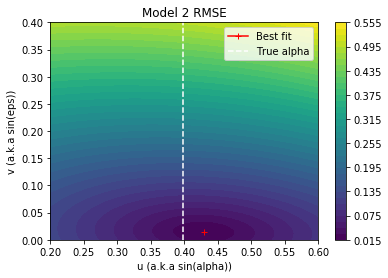

In [31]:

def plot_model2_rms(raw_data, model2_optres):
    u_opt, v_opt = model2_optres.x
    
    us = np.linspace(0.2, 0.6, 1e2)
    vs = np.linspace(0.0, 0.4, 1e2)

    C2 = np.zeros((np.shape(vs)[0], np.shape(us)[0]))
    for m in raw_data:
        lat, lng = m['pos']
        dl_s = parse_daylight_s(m['daylight'])
        year_f = parse_year_fraction(m['date'], lng)
        psi = 2 * np.pi * (year_f - june21_yf)
        phi = lat * np.pi / 180
        night_fraction = (1 - dl_s / day_duration_s)
        t = np.cos(np.pi * night_fraction)
        Rn = np.square(t - np.matmul(np.mat(vs).transpose(), np.mat((1 - (np.cos(psi) * us) ** 2) ** (-0.5) / np.cos(phi))) - np.tan(phi) * np.cos(psi) * np.matmul(np.mat(np.ones(len(vs))).transpose(), np.mat(us)))
        C2 += Rn
    C2 = (C2 / N) ** 0.5

    fig, (ax0) = plt.subplots(nrows=1)
    im = ax0.contourf(us, vs, C2, 50)
    fig.colorbar(im, ax=ax0)
    ax0.set_title('Model 2 RMSE')
    ax0.xaxis.set_label_text('u (a.k.a sin(alpha))')
    ax0.yaxis.set_label_text('v (a.k.a sin(eps))')
    ax0.plot([u_opt], [v_opt], marker='+', color='r', label="Best fit")
    ax0.plot(np.full(len(vs), np.sin(real_tilt)), vs, color='w', linestyle='--', label="True alpha")
    ax0.legend()
    plt.show()
    
plot_model2_rms(raw_training_data, model2_optres)

This looks like a nicely convex problem, well approximated by a quadratic function, so its no surprise that a Hessian-based algorithm quickly converged to the best solution:

In [25]:
model2_optres

     fun: 0.0001239977572583541
    hess: array([[0.29566738, 0.04806548],
       [0.04806548, 1.70032203]])
     jac: array([3.64946893e-07, 1.66596319e-07])
 message: 'Optimization terminated successfully.'
    nfev: 3
    nhev: 3
     nit: 2
    njev: 3
  status: 0
 success: True
       x: array([0.42866841, 0.01458687])